# 引用库

In [1]:
#引用需要用到的库
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as image
import cv2
import os

# 调用GPU

In [4]:
#调用GPU
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()

cuda


# 初始化变量

In [3]:
#初始化变量
n_epochs = 100 #训练3个epoch
batch_size_train = 240 #训练的 batch_size
batch_size_test = 1000 #测试的 batch_size
learning_rate = 0.001 # 学习率
momentum = 0.5 # 在梯度下降过程中解决mini-batch SGD优化算法更新幅度摆动大的问题，使得收敛速度更快
log_interval = 10 # 操作间隔
random_seed = 2 # 随机种子，设置后可以得到稳定的随机数
torch.manual_seed(random_seed)

# 导入训练集并增强数据

In [4]:
#导入训练集并增强数据
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./mnist/', train=True, download=False,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.RandomAffine(degrees = 0,translate=(0.1, 0.1)),
                                   torchvision.transforms.RandomRotation((-10,10)),#将图片随机旋转（-10,10）度
                                   torchvision.transforms.ToTensor(),# 将PIL图片或者numpy.ndarray转成Tensor类型
                                   torchvision.transforms.Normalize((0.1307,), (0.3081,))])
                              ),
    batch_size=batch_size_train, shuffle=True,num_workers=4, pin_memory=True) # shuffle如果为true,每个训练epoch后，会将数据顺序打乱

# 导入测试集

In [5]:
#导入测试集
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./mnist/', train=False, download=False,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.1307,), (0.3081,))])
                              ),
    batch_size=batch_size_test, shuffle=True,num_workers=4, pin_memory=True)

In [6]:
# 训练数据 60000 张图像；测试数据 10000张图像
print(train_loader.dataset)
print(test_loader.dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1))
               RandomRotation(degrees=[-10.0, 10.0], resample=False, expand=False)
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./mnist/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [7]:
# 用 enumerate 加载测试集
examples = enumerate(test_loader)
# 获取一个 batch
batch_idx, (example_data, example_targets) = next(examples)
# 查看 batch 数据，有10000张图像的标签，tensor 大小为 [1000, 1, 28, 28]
# 即图像为 28 * 28， 1个颜色通道（灰度图）， 1000张图像
print(example_targets)
print(example_data.shape)

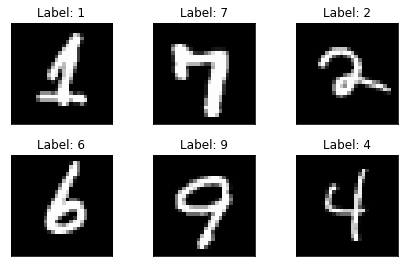

In [8]:
#查看部分图片
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)# 创建 subplot
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Label: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [9]:
example_data[1][0]

# model结构

In [5]:
#model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution layer 1
        self.conv1 = nn.Conv2d(in_channels = 1 , out_channels = 32, kernel_size = 5, stride = 1, padding = 0 )
        self.relu1 = nn.ReLU()
        self.batch1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels =32 , out_channels = 32, kernel_size = 5, stride = 1, padding = 0 )
        self.relu2 = nn.ReLU()
        self.batch2 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv1_drop = nn.Dropout(0.25)

        # Convolution layer 2
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 0 )
        self.relu3 = nn.ReLU()
        self.batch3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 0 )
        self.relu4 = nn.ReLU()
        self.batch4 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2_drop = nn.Dropout(0.25)

        # Fully-Connected layer 1
        
        self.fc1 = nn.Linear(576,256)
        self.fc1_relu = nn.ReLU()
        self.dp1 = nn.Dropout(0.5)
        
        # Fully-Connected layer 2
        self.fc2 = nn.Linear(256,10)
                
    def forward(self, x):
        # conv layer 1 的前向计算，3行代码
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.batch1(out)
        
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.batch2(out)
        
        out = self.maxpool1(out)
        out = self.conv1_drop(out)

        # conv layer 2 的前向计算，4行代码
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.batch3(out)
        
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.batch4(out)
        
        out = self.maxpool2(out)
        out = self.conv2_drop(out)

        #Flatten拉平操作
        out = out.view(out.size(0),-1)

        #FC layer的前向计算（2行代码）
        out = self.fc1(out)
        out = self.fc1_relu(out)
        out = self.dp1(out)
        
        out = self.fc2(out)

        return F.log_softmax(out,dim = 1)

# 权值初始化

In [11]:
#权值初始化
def weight_init(m):
    # 1. 根据网络层的不同定义不同的初始化方式  
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    # 也可以判断是否为conv2d，使用相应的初始化方式 
    '''
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)
    # 是否为批归一化层
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    ''' 

He初始化基本思想是，当使用ReLU做为激活函数时，Xavier的效果不好，原因在于，当RelU的输入小于0时，其输出为0，相当于该神经元被关闭了，影响了输出的分布模式。



因此He初始化，在Xavier的基础上，假设每层网络有一半的神经元被关闭，于是其分布的方差也会变小。经过验证发现当对初始化值缩小一半时效果最好，故He初始化可以认为是Xavier初始/2的结果。

# 实例化网络，设置优化器

In [12]:
# 实例化一个网络
network = CNNModel()
network.to(device)
network.apply(weight_init)
# 设置优化器，用stochastic gradient descent，设置学习率，设置momentum
#optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
#optimizer = optim.Adam(network.parameters(), lr=learning_rate)
optimizer = optim.RMSprop(network.parameters(),lr=learning_rate,alpha=0.99,momentum = momentum)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True, threshold=0.00005, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

* torch.optim.lr_scheduler.ReduceLROnPlateau:该方法提供了一些基于训练过程中的某些测量值对学习率进行动态的下降.
* optimer指的是网络的优化器
* mode (str) ，可选择‘min’或者‘max’，min表示当监控量停止下降的时候，学习率将减小，max表示当监控量停止上升的时候，学习率将减小。默认值为‘min’
* factor 学习率每次降低多少，new_lr = old_lr * factor
* patience=10，容忍网路的性能不提升的次数，高于这个次数就降低学习率
* verbose（bool） - 如果为True，则为每次更新向stdout输出一条消息。 默认值：False
* threshold（float） - 测量新最佳值的阈值，仅关注重大变化。 默认值：1e-4
* cooldown： 减少lr后恢复正常操作之前要等待的时期数。 默认值：0。
*min_lr,学习率的下限
* eps ，适用于lr的最小衰减。 如果新旧lr之间的差异小于eps，则忽略更新。 默认值：1e-8。

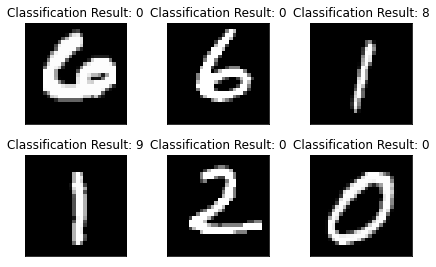

In [13]:
# 先看一下模型的识别能力
# 可以看到没有经过训练的模型在测试集上的表现是很差的，所有的图像几乎都识别错了
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    output = network(example_data.to(device))
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Classification Result: {}".format(
        output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
plt.show()

# 定义存储数据的列表

In [14]:
#定义存储数据的列表
train_losses = []
train_counter = []
train_acces = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_acces = []

# 定义训练函数

In [15]:
# 定义训练函数
def train(epoch):
    
    network.train() # 将网络设为 training 模式
    train_correct = 0
    # 对一组 batch 
    for batch_idx, (data, target) in enumerate(train_loader): 
        # 通过enumerate获取batch_id, data, and label
        # 1-将梯度归零
        optimizer.zero_grad()
        
        # 2-传入一个batch的图像，并前向计算
        output = network(data.to(device))
        
        # 3-计算损失
        loss = F.nll_loss(output, target.to(device))
        
        # 4-反向传播
        loss.backward()
        
        # 5-优化参数
        optimizer.step()
        #exp_lr_scheduler.step()
        
        
        train_pred = output.data.max(dim=1, keepdim=True)[1] # 取 output 里最大的那个类别, 
             # dim = 1表示去每行的最大值，[1]表示取最大值的index，而不去最大值本身[0]    

        train_correct += train_pred.eq(target.data.view_as(train_pred).to(device)).sum() # 比较并求正确分类的个数
        
        print('\r 第 {} 次 Train Epoch: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()),end = '')

        # 每第10个batch (log_interval = 10)
        if batch_idx  % log_interval == 0:
            #print(batch_idx)
            #打印以下信息：第几个epoch，第几张图像， 总训练图像数, 完成百分比，目前的loss
            '''print('\r 第 {} 次 Train Epoch: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()),end = '')
            '''
            # 把目前的 loss加入到 train_losses,后期画图用
            train_losses.append(loss.item())
            # 计数
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            '''
            # 每个batch训练完后保存模型 
            torch.save(network.state_dict(), './model.pth')

            # 每个batch训练完后保存优化器
            torch.save(optimizer.state_dict(), './optimizer.pth')
            '''
    
    train_acc = train_correct / len(train_loader.dataset)
    train_acces.append(train_acc.cpu().numpy().tolist())
    print('\tTrain Accuracy:{:.2f}%'.format(100. * train_acc))

# 定义测试函数

In [16]:
# 定义测试函数
def test(epoch):
    network.eval() # 将网络设为 evaluating 模式
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.to(device)) # 传入这一组 batch，进行前向计算
            #test_loss += F.nll_loss(output, target, size_average=False).item()
            test_loss += F.nll_loss(output, target.to(device), reduction='sum').item()

            pred = output.data.max(dim=1, keepdim=True)[1] # 取 output 里最大的那个类别, 
             # dim = 1表示去每行的最大值，[1]表示取最大值的index，而不去最大值本身[0]    

            correct += pred.eq(target.data.view_as(pred).to(device)).sum() # 比较并求正确分类的个数
    acc = correct / len(test_loader.dataset)
    test_acces.append(acc.cpu().numpy().tolist())
    
    test_loss /= len(test_loader.dataset) # 平均 loss， len 为 10000
    test_losses.append(test_loss) # 记录该 epoch 下的 test_loss
    
    if test_acces[-1] >= max(test_acces):
        # 每个batch训练完后保存模型 
        torch.save(network.state_dict(), './model02.pth')

        # 每个batch训练完后保存优化器
        torch.save(optimizer.state_dict(), './optimizer02.pth')
    
    # 打印相关信息 如：Test set: Avg. loss: 2.3129, Accuracy: 1205/10000 (12%)
    '''
    print('\rTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)),end = '')
    '''
    print('\r Test set \033[1;31m{}\033[0m : Avg. loss: {:.4f}, Accuracy: {}/{}  \033[1;31m({:.2f}%)\033[0m\n'\
          .format(epoch,test_loss, correct,len(test_loader.dataset),100. * acc),end = '') 

# 查看模型的识别能力

In [17]:
# 先看一下模型的识别能力，可以看到没有经过训练的模型在测试集上的表现是很差的，大概只有10%左右的正确识别率
test(1)

 Test set 1 : Avg. loss: 2.3031, Accuracy: 892/10000  (8.92%)


# 训练模型

In [18]:
### 训练！！！ 并在每个epoch之后测试 ###
###################################################
# 根据epoch数正式训练并在每个epoch训练结束后测试
for epoch in range(1, n_epochs + 1):
    scheduler.step(test_acces[-1])
    train(epoch)
    test(epoch)
print('\n\033[1;31mThe network Max Avg Accuracy : {:.2f}%\033[0m'.format(100. * max(test_acces)))

 第 1 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.089140	Train Accuracy:91.03%
 Test set 1 : Avg. loss: 0.0303, Accuracy: 9895/10000  (98.95%)
 第 2 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.110214	Train Accuracy:96.59%
 Test set 2 : Avg. loss: 0.0339, Accuracy: 9904/10000  (99.04%)
 第 3 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.083356	Train Accuracy:97.36%
 Test set 3 : Avg. loss: 0.0251, Accuracy: 9919/10000  (99.19%)
 第 4 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.096341	Train Accuracy:97.74%
 Test set 4 : Avg. loss: 0.0259, Accuracy: 9921/10000  (99.21%)
 第 5 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.042698	Train Accuracy:97.95%
 Test set 5 : Avg. loss: 0.0229, Accuracy: 9934/10000  (99.34%)
 第 6 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.034205	Train Accuracy:98.09%
 Test set 6 : Avg. loss: 0.0196, Accuracy: 9947/10000  (99.47%)
 第 7 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.069153	Train Accuracy:98.17%
 Test set 7 : Avg. loss: 0.0208, Accuracy: 9947/10000  (99.47%)
 第 8 次

 第 49 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.012707	Train Accuracy:99.50%
 Test set 49 : Avg. loss: 0.0108, Accuracy: 9972/10000  (99.72%)
 第 50 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.012373	Train Accuracy:99.52%
 Test set 50 : Avg. loss: 0.0109, Accuracy: 9970/10000  (99.70%)
 第 51 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.009760	Train Accuracy:99.55%
 Test set 51 : Avg. loss: 0.0107, Accuracy: 9972/10000  (99.72%)
 第 52 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.025321	Train Accuracy:99.53%
 Test set 52 : Avg. loss: 0.0106, Accuracy: 9970/10000  (99.70%)
 第 53 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.004454	Train Accuracy:99.50%
 Test set 53 : Avg. loss: 0.0111, Accuracy: 9971/10000  (99.71%)
Epoch    54: reducing learning rate of group 0 to 1.5625e-05.
 第 54 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.002725	Train Accuracy:99.50%
 Test set 54 : Avg. loss: 0.0108, Accuracy: 9969/10000  (99.69%)
 第 55 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.010469	Train Accuracy:99

# 可视化训练结果

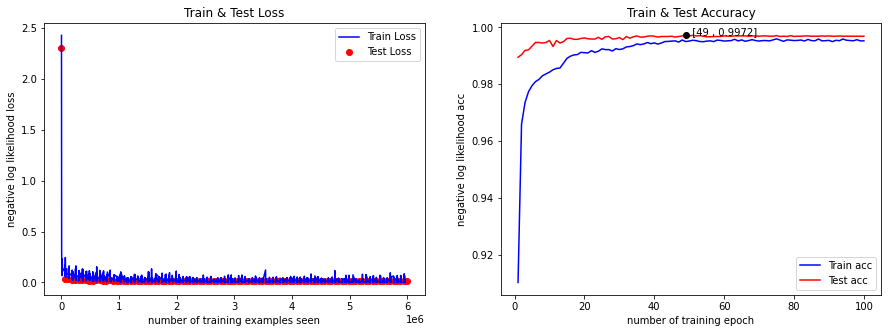

In [22]:
#可视化
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.title('Train & Test Loss')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

plt.subplot(122)

max_test_acces_epoch = test_acces.index(max(test_acces))
max_test_acces = round(max(test_acces),4)


plt.plot([epoch+1 for epoch in range(n_epochs) ], train_acces, color='blue')
plt.plot([epoch+1 for epoch in range(n_epochs) ], test_acces[1:], color='red')

plt.plot(max_test_acces_epoch,max_test_acces,'ko') #最大值点

show_max='  ['+str(max_test_acces_epoch )+' , '+str(max_test_acces)+']'
plt.annotate(show_max,xy=(max_test_acces_epoch,max_test_acces), 
             xytext=(max_test_acces_epoch,max_test_acces))

plt.legend(['Train acc', 'Test acc'], loc='lower right')
plt.title('Train & Test Accuracy')
#plt.ylim(0.8, 1)
plt.xlabel('number of training epoch')
plt.ylabel('negative log likelihood acc')
plt.show()

# 预测

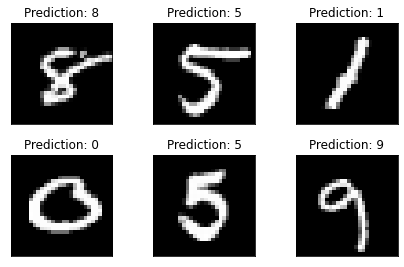

In [20]:
#预测
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    output = network(example_data.to(device))
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
        plt.title("Prediction: {}".format(
        output.data.max(1, keepdim=True)[1][i].item()))
        plt.xticks([])
        plt.yticks([])
    plt.show()

# 图片处理

In [8]:
#图片处理
def imageProcess(img):
    #处理图片
    data_transform = torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32),
         torchvision.transforms.CenterCrop(28),
         torchvision.transforms.ToTensor(),
         torchvision.transforms.Normalize((0.1307,), (0.3081,))])
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)# 灰度处理
    retval, dst = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)# 二值化
    fanse = cv2.bitwise_not(dst)#黑白反转

    #将BGR图像转变成RGB图像：即将cv2.imread转换成Image.open
    imgs = Image.fromarray(cv2.cvtColor(fanse, cv2.COLOR_BGR2RGB))
    imgs = imgs.convert('L') #将三通道图像转换成单通道灰度图像
    imgs = data_transform(imgs)#处理图像
    
    return imgs

# 加载模型

In [6]:
#加载模型
'''
network = CNNModel()


model_path = "./model02.pth"
network.load_state_dict(torch.load(model_path))
network.eval()
'''


CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_drop): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu4): ReLU()
  (batch4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_drop): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=576, ou

# 预测手写数字

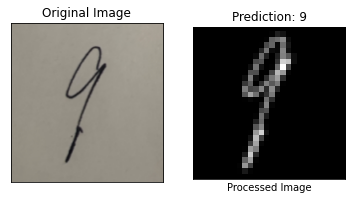

In [11]:
#预测手写数字
path = 'E:/jupyter_notebook/test/' #图片保存路径
with torch.no_grad():   
    img = cv2.imread(path + '9.jpg')#预测图片
    imgs = imageProcess(img)
    if imgs.shape == torch.Size([1,28,28]):
        imgs = torch.unsqueeze(imgs, dim=0) #在最前面增加一个维度
    output = network(imgs.to(device))
    plt.tight_layout()
    plt.subplot(121)
    img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.imshow(img)
    plt.title("Original Image")
    plt.xticks([])
    plt.yticks([])

    
    plt.subplot(122)
    plt.imshow(imgs[0][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(output.data.max(dim = 1, keepdim=True)[1].item()))
    plt.xlabel("Processed Image")
    plt.xticks([])
    plt.yticks([])
    plt.show()

# 调整参数，优化模型

In [28]:
# 实例化一个网络
network = CNNModel()
#加载模型
model_path = "./model02.pth"
network.load_state_dict(torch.load(model_path))

network.to(device)


#network.apply(weights_init)
# 设置优化器，用stochastic gradient descent，设置学习率，设置momentum
#optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
#optimizer = optim.Adam(network.parameters(), lr=learning_rate)
#optimizer = optim.RMSprop(network.parameters(),lr=learning_rate,alpha=0.90,momentum = momentum)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True, threshold=0.00005, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)


In [29]:
test(1)

 Test set 1 : Avg. loss: 0.0107, Accuracy: 9972/10000  (99.72%)


In [30]:
for epoch in range(101, 121):
    scheduler.step(test_losses[-1])
    train(epoch)
    test(epoch)
print('\n\033[1;31mThe network Max Avg Accuracy : {:.2f}%\033[0m'.format(100. * max(test_acces)))

 第 101 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.022774	Train Accuracy:99.54%
 Test set 101 : Avg. loss: 0.0107, Accuracy: 9972/10000  (99.72%)
 第 102 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.015190	Train Accuracy:99.54%
 Test set 102 : Avg. loss: 0.0108, Accuracy: 9970/10000  (99.70%)
 第 103 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.001341	Train Accuracy:99.50%
 Test set 103 : Avg. loss: 0.0108, Accuracy: 9971/10000  (99.71%)
 第 104 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.003677	Train Accuracy:99.52%
 Test set 104 : Avg. loss: 0.0109, Accuracy: 9971/10000  (99.71%)
 第 105 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.018330	Train Accuracy:99.51%
 Test set 105 : Avg. loss: 0.0107, Accuracy: 9969/10000  (99.69%)
 第 106 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.091545	Train Accuracy:99.51%
 Test set 106 : Avg. loss: 0.0108, Accuracy: 9972/10000  (99.72%)
 第 107 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.025268	Train Accuracy:99.54%
 Test set 107 : Avg. loss: 0.0107, Accuracy:

In [31]:
# 实例化一个网络
network = CNNModel()
#加载模型
model_path = "./model02.pth"
network.load_state_dict(torch.load(model_path))

network.to(device)


#network.apply(weights_init)
# 设置优化器，用stochastic gradient descent，设置学习率，设置momentum
#optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
#optimizer = optim.Adam(network.parameters(), lr=learning_rate)
optimizer = optim.RMSprop(network.parameters(),lr=0.0001,alpha=0.99,momentum = momentum)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True, threshold=0.00001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-09)


In [32]:
test(1)

 Test set 1 : Avg. loss: 0.0109, Accuracy: 9972/10000  (99.72%)


In [33]:
for epoch in range(121, 126):
    scheduler.step(train_acces[-1])
    train(epoch)
    test(epoch)
print('\n\033[1;31mThe network Max Avg Accuracy : {:.2f}%\033[0m'.format(100. * max(test_acces)))

 第 121 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.005819	Train Accuracy:99.49%
 Test set 121 : Avg. loss: 0.0111, Accuracy: 9968/10000  (99.68%)
 第 122 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.003215	Train Accuracy:99.50%
 Test set 122 : Avg. loss: 0.0109, Accuracy: 9969/10000  (99.69%)
 第 123 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.010746	Train Accuracy:99.53%
 Test set 123 : Avg. loss: 0.0114, Accuracy: 9970/10000  (99.70%)
 第 124 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.019579	Train Accuracy:99.51%
 Test set 124 : Avg. loss: 0.0114, Accuracy: 9971/10000  (99.71%)
 第 125 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.010792	Train Accuracy:99.54%
 Test set 125 : Avg. loss: 0.0112, Accuracy: 9969/10000  (99.69%)

The network Max Avg Accuracy : 99.72%


In [34]:
for epoch in range(126, 146):
    scheduler.step(train_acces[-1])
    train(epoch)
    test(epoch)
print('\n\033[1;31mThe network Max Avg Accuracy : {:.2f}%\033[0m'.format(100. * max(test_acces)))

 第 126 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.121945	Train Accuracy:99.57%
 Test set 126 : Avg. loss: 0.0115, Accuracy: 9967/10000  (99.67%)
 第 127 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.005328	Train Accuracy:99.53%
 Test set 127 : Avg. loss: 0.0117, Accuracy: 9966/10000  (99.66%)
 第 128 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.014597	Train Accuracy:99.50%
 Test set 128 : Avg. loss: 0.0108, Accuracy: 9969/10000  (99.69%)
 第 129 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.036602	Train Accuracy:99.51%
 Test set 129 : Avg. loss: 0.0116, Accuracy: 9965/10000  (99.65%)
 第 130 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.000685	Train Accuracy:99.51%
 Test set 130 : Avg. loss: 0.0115, Accuracy: 9968/10000  (99.68%)
Epoch    11: reducing learning rate of group 0 to 5.0000e-05.
 第 131 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.013627	Train Accuracy:99.51%
 Test set 131 : Avg. loss: 0.0112, Accuracy: 9967/10000  (99.67%)
 第 132 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.013211	Trai

In [35]:
# 实例化一个网络
network = CNNModel()
#加载模型
model_path = "./model02.pth"
network.load_state_dict(torch.load(model_path))

network.to(device)


#network.apply(weights_init)
# 设置优化器，用stochastic gradient descent，设置学习率，设置momentum
#optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
#optimizer = optim.Adam(network.parameters(), lr=learning_rate)
optimizer = optim.RMSprop(network.parameters(),lr=learning_rate,alpha=0.99,momentum = momentum)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, verbose=True, threshold=1e-06, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-09)


In [36]:
for epoch in range(146, 171):
    scheduler.step(train_acces[-1])
    train(epoch)
    test(epoch)
print('\n\033[1;31mThe network Max Avg Accuracy : {:.2f}%\033[0m'.format(100. * max(test_acces)))

 第 146 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.062502	Train Accuracy:98.60%
 Test set 146 : Avg. loss: 0.0143, Accuracy: 9962/10000  (99.62%)
 第 147 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.062637	Train Accuracy:98.96%
 Test set 147 : Avg. loss: 0.0179, Accuracy: 9944/10000  (99.44%)
Epoch     3: reducing learning rate of group 0 to 5.0000e-04.
 第 148 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.039677	Train Accuracy:99.14%
 Test set 148 : Avg. loss: 0.0120, Accuracy: 9966/10000  (99.66%)
 第 149 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.032650	Train Accuracy:99.24%
 Test set 149 : Avg. loss: 0.0138, Accuracy: 9963/10000  (99.63%)
Epoch     5: reducing learning rate of group 0 to 2.5000e-04.
 第 150 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.014351	Train Accuracy:99.36%
 Test set 150 : Avg. loss: 0.0124, Accuracy: 9969/10000  (99.69%)
 第 151 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.006440	Train Accuracy:99.27%
 Test set 151 : Avg. loss: 0.0134, Accuracy: 9965/10000  (99.65%)


In [41]:
# 实例化一个网络
network = CNNModel()
#加载模型
model_path = "./model02.pth"
network.load_state_dict(torch.load(model_path))

network.to(device)


#network.apply(weights_init)
# 设置优化器，用stochastic gradient descent，设置学习率，设置momentum
#optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
#optimizer = optim.Adam(network.parameters(), lr=learning_rate)
optimizer = optim.RMSprop(network.parameters(),lr=2.4414e-07,alpha=0.99,momentum = momentum)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True, threshold=1e-10, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-12)


In [42]:
for epoch in range(171, 201):
    scheduler.step(test_losses[-1])
    train(epoch)
    test(epoch)
print('\n\033[1;31mThe network Max Avg Accuracy : {:.2f}%\033[0m'.format(100. * max(test_acces)))

 第 171 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.006418	Train Accuracy:99.43%
 Test set 171 : Avg. loss: 0.0111, Accuracy: 9974/10000  (99.74%)
 第 172 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.003037	Train Accuracy:99.44%
 Test set 172 : Avg. loss: 0.0111, Accuracy: 9975/10000  (99.75%)
 第 173 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.032966	Train Accuracy:99.46%
 Test set 173 : Avg. loss: 0.0111, Accuracy: 9974/10000  (99.74%)
 第 174 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.013580	Train Accuracy:99.44%
 Test set 174 : Avg. loss: 0.0110, Accuracy: 9975/10000  (99.75%)
 第 175 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.022338	Train Accuracy:99.43%
 Test set 175 : Avg. loss: 0.0110, Accuracy: 9974/10000  (99.74%)
 第 176 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.006796	Train Accuracy:99.44%
 Test set 176 : Avg. loss: 0.0112, Accuracy: 9974/10000  (99.74%)
 第 177 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.001646	Train Accuracy:99.49%
 Test set 177 : Avg. loss: 0.0110, Accuracy: